# Feature Engineering, Preprocessing, and Modeling

In [391]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
import mca
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import  MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
import warnings
import time
import re
from pdpbox import pdp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# import data
bgg = pd.read_csv('Data/browse_cmf_credits_raw.csv', index_col=0)
pd.set_option('max_colwidth', 120)

In [3]:
# checking that the data types are correct
bgg.dtypes

avg_rating       float64
geek_rating      float64
num_voters         int64
title             object
full_game_url     object
rank               int64
game_id            int64
category          object
mechanic          object
family            object
age                int64
max_play_time      int64
max_players        int64
min_play_time      int64
min_players        int64
weight           float64
dtype: object

In [4]:
# checking for null values
bgg.isnull().sum()

avg_rating          0
geek_rating         0
num_voters          0
title               0
full_game_url       0
rank                0
game_id             0
category          211
mechanic         1567
family           4614
age                 0
max_play_time       0
max_players         0
min_play_time       0
min_players         0
weight              0
dtype: int64

In [3]:
# filling nulls in categorical labels with "None"
bgg.fillna('None', inplace=True)

# confirming categorical nulls are replaced
bgg[['category','mechanic','family']].isnull().sum()

category    0
mechanic    0
family      0
dtype: int64

The family label is sparse with 2,748 different families. Using this as a feature would increase dimensionality significantly, but also many of families are unique or specific to a game or set of games, so this will not generalize well to new data. However, as we saw in EDA, Kickstarter games have a statistically higher average Geek Rating, so I do want to create a column indicating if a game was or wasn't on Kickstarter.

In [4]:
# create new column named Kickstarter and drop family column
bgg['kickstarter'] = bgg['family'].str.contains('Kickstarter')
bgg.drop(columns=['family'], inplace=True)

In [5]:
# creating dummy columns for category label - removing spaces to split correctly
bgg['category'] = bgg['category'].str.replace(' ','')
cat_dummy = bgg['category'].str.get_dummies(',').add_prefix('CATEGORY').replace({1:True,0:False})

# creating dummy columns for mechanic label
# three mechanics have commas which need to be removed before cleaning and creating dummies 
bgg['mechanic'] = bgg['mechanic'].str.replace('Deck, Bag, and Pool Building', 'Deck Bag and Pool Building')
bgg['mechanic'] = bgg['mechanic'].str.replace('I Cut, You Choose', 'I Cut You Choose')
bgg['mechanic'] = bgg['mechanic'].str.replace('Worker Placement, Different Worker Types', 'Worker Placement Different Worker Types')

bgg['mechanic'] = bgg['mechanic'].str.replace(' ','')

mech_dummy = bgg['mechanic'].str.get_dummies(',').add_prefix('MECHANIC').replace({1:True,0:False})

# concatenating with original dataframe and dropping the category and mechanic columns
bgg = pd.concat([bgg, cat_dummy, mech_dummy], axis=1)
bgg.drop(columns=['category','mechanic'], inplace=True)

# remove all other special characters
bgg = bgg.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Train-Test-Split, Imputing, and Scaling

The target variable will be Geek Rating, specifically if a game be in the top 1,000. Since its derived from average rating we will drop average rating. Number of voters correlates with Geek Rating, but in this context I want the model to predict the rating of a new game. Any value for number of voters for a new game would be arbitrary. Title, game url, rank, and game id are not relevant to the model and can be dropped.

In [6]:
# creating binary response column for top 1000 games
bgg['top_1000'] = bgg['rank'] <= 1000
bgg['top_1000'].replace({True:1,False:0}, inplace=True)

#### Train-Test-Split

In [7]:
# setting features, X and response variable, y
X = bgg.drop(columns=['avg_rating','geek_rating','num_voters','title','full_game_url','rank','game_id','top_1000'])
y = bgg.top_1000

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True)

#### Imputing and Scaling

In [8]:
# subsetting numerical values to be imputed
X_train_transform = X_train[['age', 'max_play_time','max_players','min_play_time','min_players','weight']]
X_test_transform = X_test[['age', 'max_play_time','max_players','min_play_time','min_players','weight']]

# instantiating the imputer and scaler
knn_imputer = KNNImputer(missing_values=0)
scaler = MinMaxScaler()

# fit to training data 
knn_imputer.fit(X_train_transform)
scaler.fit(X_train_transform)

# transform training data 
X_train_transform = pd.DataFrame(scaler.transform(knn_imputer.transform(X_train_transform)),
                              columns=['age', 'max_play_time','max_players','min_play_time',
                                       'min_players','weight'])

# transform test data
X_test_transform = pd.DataFrame(scaler.transform(knn_imputer.transform(X_test_transform)),
                              columns=['age', 'max_play_time','max_players','min_play_time',
                                       'min_players','weight'])

# concatenate imputed columns back with categorical columns
X_train = pd.concat([X_train_transform, X_train.iloc[:,6:].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_transform, X_test.iloc[:,6:].reset_index(drop=True)], axis=1)

KNNImputer(missing_values=0)

MinMaxScaler()

### Modeling
Trying some out of the box models to get a baseline. First I define functions to run and plot the models and store the resultes in a dataframe. Because the data set is imbalanced, the precision-recall AUC and F1 scores will be the deciding factors.

In [10]:
# create dataframe to store the results
model_df = pd.DataFrame(columns=['y_pred','y_pred_prob','fpr','tpr','roc_threshold','roc_auc','accuracy','precision','recall','precision-recall_threshold','f1','precision-recall_auc'])

In [11]:
def run_model(model, model_name, fit=True, xtrain=X_train, ytrain=y_train, xtest=X_test, ytest=y_test, **parameters):
    """runs a model and adds metrics to model_df"""
    global model_df
    
    # instantiate and fit model - if fit == False then just calculate the metrics
    if fit == True:
        model = model(**parameters).fit(xtrain, ytrain)
    else:
        pass
    
    # metrics
    y_pred = model.predict(xtest)
    y_pred_prob = model.predict_proba(xtest)[:,1]
    fpr, tpr, roc_threshold = roc_curve(ytest, y_pred_prob)
    roc_auc = roc_auc_score(ytest, y_pred_prob)
    precision, recall, pr_threshold = precision_recall_curve(ytest, y_pred_prob)
    f1 = f1_score(ytest, y_pred)
    pr_auc = auc(recall, precision)
    accuracy = accuracy_score(ytest, y_pred) 

    # create dataframe of results
    model_results = pd.DataFrame.from_dict({model_name:{'y_pred':y_pred, 'y_pred_prob':y_pred_prob,
                                              'fpr':fpr,'tpr':tpr, 'roc_threshold':roc_threshold,
                                              'roc_auc':roc_auc, 'accuracy':accuracy,
                                              'precision':precision, 'recall':recall,
                                              'precision-recall_threshold' : pr_threshold,
                                              'f1':f1, 'precision-recall_auc':pr_auc}},
                                           orient='index')

    
    # concats results with df
    model_df = pd.concat([model_df, model_results])

    #drops previous record if model_name is duplicated
    model_df= model_df[~model_df.index.duplicated(keep='last')]
    
    return model_df[['roc_auc','accuracy','precision-recall_auc','f1']].tail(1)

In [12]:
def plot_eval_curves(model_name):
    """plot ROC and Precision/Recall Curve for a given model in model_df"""
    global model_df
    
    h_line = len(y_test[y_test==1]) / len(y_test) # horizontal line in precision/recall curve
    _ = plt.subplots(figsize=(12,6))
    
    # plot ROC curve
    _ = plt.subplot(1,2,1)
    _ = plt.plot([0,1],[0,1], 'k--')
    _ = plt.plot(model_df.loc[model_name]['fpr'], model_df.loc[model_name]['tpr'])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title(model_name + ' ROC Curve')
    _ = plt.legend(['roc auc score: ' + str(round(model_df.loc[model_name]['roc_auc'],4))])
    
    # plot precision-recall curve
    _ = plt.subplot(1,2,2)
    _ = plt.plot([0, 1], [h_line, h_line], linestyle='--')
    _ = plt.plot(model_df.loc[model_name]['recall'], model_df.loc[model_name]['precision'])
    _ = plt.xlabel('Recall')
    _ = plt.ylabel('Precision')
    _ = plt.title(model_name + ' Precision-Recall Curve')
    _ = plt.legend(['precision/recall auc score: ' + 
                    str(round(model_df.loc[model_name]['precision-recall_auc'],4))])
    
    plt.tight_layout()

,roc_auc,accuracy,precision-recall_auc,f1
Logistic Regression,0.884259,0.835962,0.379357,0.338983


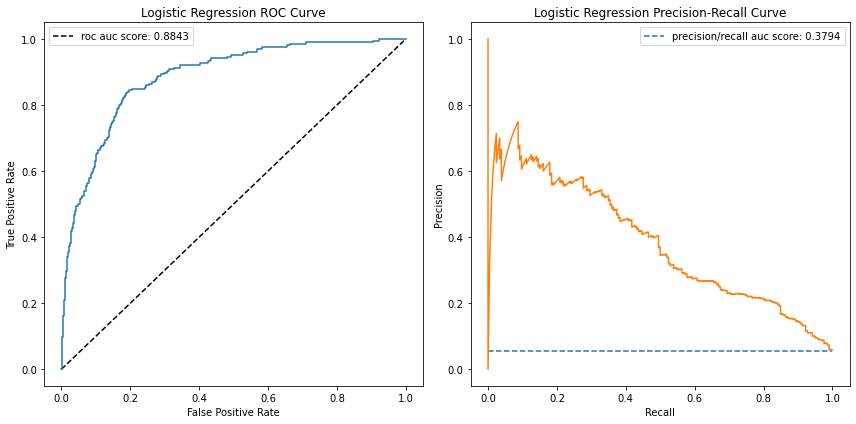

In [80]:
model = LogisticRegression
model_name = 'Logistic Regression'
parameters = {'class_weight':'balanced', 'max_iter':5000, "random_state":23}

run_model(model=model, model_name=model_name, **parameters)
plot_eval_curves(model_name)

,roc_auc,accuracy,precision-recall_auc,f1
Random Forest,0.871578,0.945846,0.394824,0.0


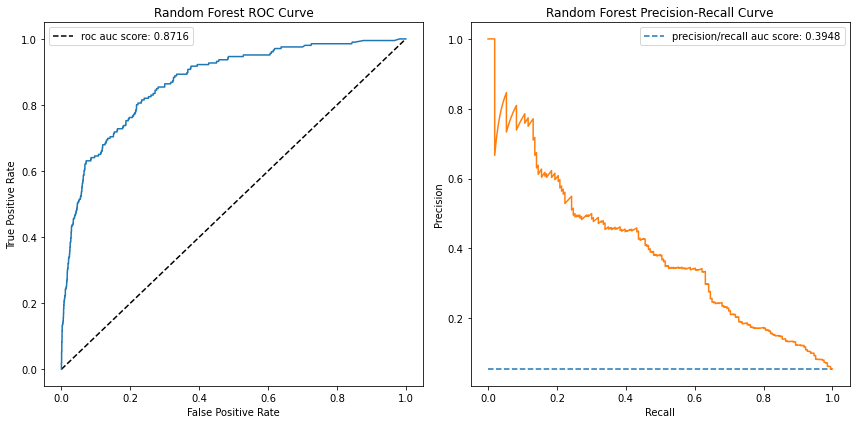

In [81]:
model = RandomForestClassifier
model_name = 'Random Forest'
parameters = {"random_state":23, "max_depth":5}

run_model(model=model, model_name=model_name, **parameters)
plot_eval_curves("Random Forest")

,roc_auc,accuracy,precision-recall_auc,f1
Gradient Boost,0.882036,0.950315,0.420441,0.222222


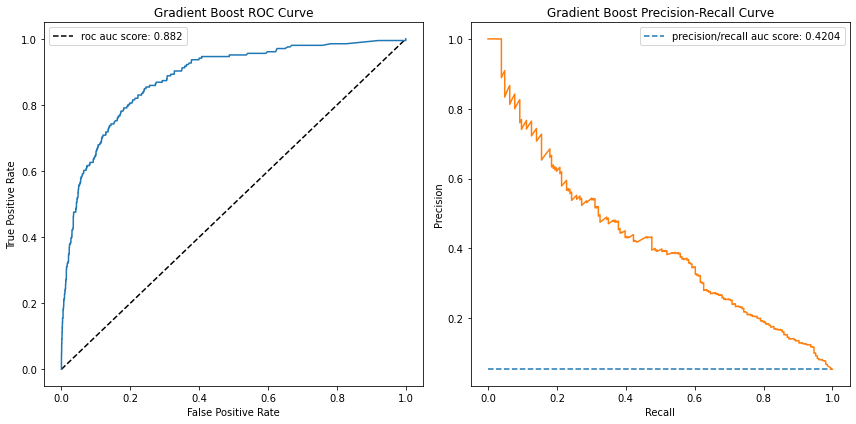

In [82]:
model = GradientBoostingClassifier
model_name = 'Gradient Boost'
parameters = {'n_estimators':100, 'max_depth':3, "random_state":23}

run_model(model=model, model_name=model_name, **parameters)
plot_eval_curves(model_name)

123 neighbors


,roc_auc,accuracy,precision-recall_auc,f1
kNeightbors,0.840884,0.945846,0.263666,0.0


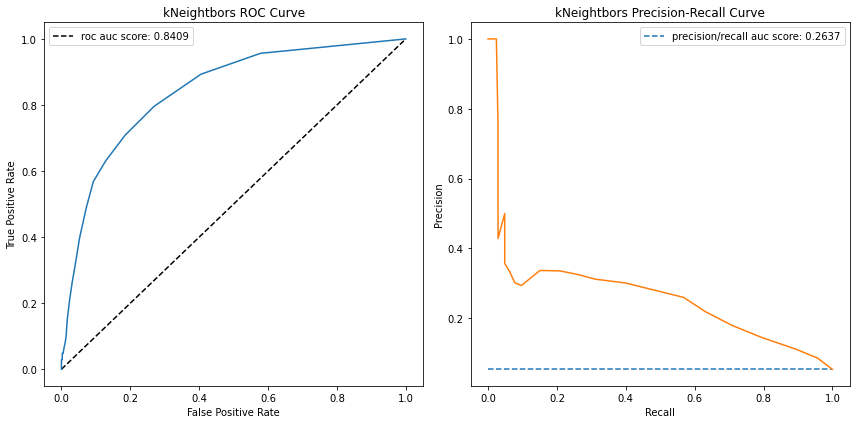

In [83]:
model = KNeighborsClassifier
model_name = 'kNeightbors'
parameters = {'n_neighbors':round(np.sqrt(len(X_train)))}

print(f'{round(np.sqrt(len(X_train)))} neighbors')
run_model(model=model, model_name=model_name, **parameters)
plot_eval_curves(model_name)

,roc_auc,accuracy,precision-recall_auc,f1
LGBMClassifier,0.908223,0.94979,0.431246,0.305455


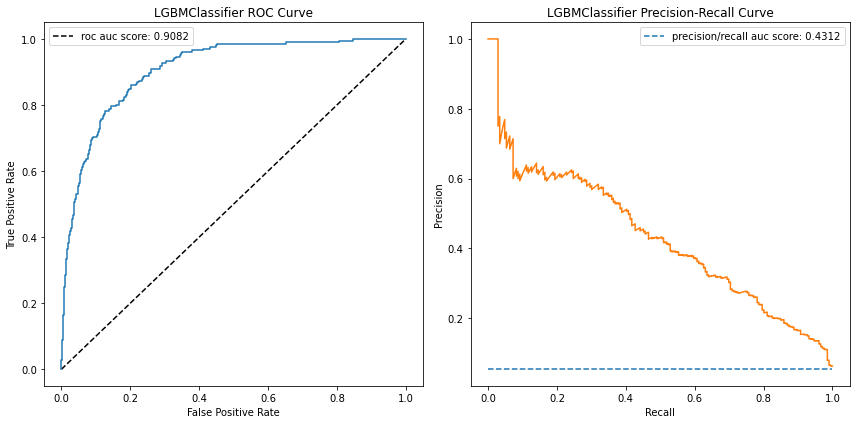

In [84]:
model = lgb.LGBMClassifier
model_name = 'LGBMClassifier'
parameters = {'n_estimators':100, 'max_depth':10, 'random_state':23}

run_model(model=model, model_name=model_name, xtrain=X_train, **parameters)
plot_eval_curves(model_name)

In [85]:
model_df[['roc_auc','accuracy','precision-recall_auc','f1']]

,roc_auc,accuracy,precision-recall_auc,f1
Logistic Regression,0.884259,0.835962,0.379357,0.338983
Random Forest,0.871578,0.945846,0.394824,0.000000
Gradient Boost,0.882036,0.950315,0.420441,0.222222
kNeightbors,0.840884,0.945846,0.263666,0.000000
LGBMClassifier,0.908223,0.949790,0.431246,0.305455


Of the models tried, LGBMClassifier did the best. Let's see what we can do to make it better.

#### Multiple Correspondence Analysis (Dimensionality Reduction)
This dataset has high cardinality, it should help if we can reduce the number of features.

In [21]:
# subset categorical columns
mca_train_df = X_train.iloc[:,6:]
mca_test_df = X_test.iloc[:,6:]

# initiate mca object
mca = mca.MCA(mca_train_df)

#transform train data
mca_train_df = pd.DataFrame(mca.fs_r(0.9)) # 0.9 = preserve 90% of varaince

# combine train data with numerical features
X_train_mca = pd.concat([X_train.iloc[:,:6], mca_train_df],axis=1)

#transform test data N=number of factors to keep
mca_test_df = pd.DataFrame(mca.fs_r_sup(mca_test_df, N=X_train_mca.iloc[:,6:].shape[1]))

# combine test data with numerical features
X_test_mca = pd.concat([X_test.iloc[:,:6], mca_test_df], axis=1)


print(f'reduced catigorical data from {X_train.iloc[:,6:].shape[1]} columns to {X_train_mca.iloc[:,6:].shape[1]} columns')

reduced catigorical data from 268 columns to 164 columns


,roc_auc,accuracy,precision-recall_auc,f1
LGBMClassifier MCA,0.867258,0.94795,0.362483,0.307692


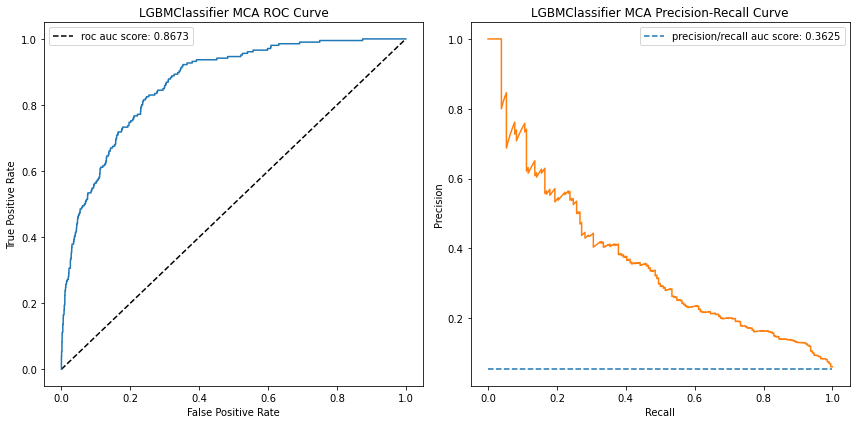

In [86]:
model = lgb.LGBMClassifier
model_name = 'LGBMClassifier MCA'
parameters = {'n_estimators':100, 'max_depth':10, 'random_state':23}

run_model(model=model, model_name=model_name, xtrain=X_train_mca, xtest=X_test_mca, **parameters)
plot_eval_curves(model_name)

In [87]:
model_df[model_df.index.str.contains('LGBM')][['roc_auc','accuracy','precision-recall_auc','f1']]

,roc_auc,accuracy,f1,precision-recall_auc
LGBMClassifier,0.908223,0.94979,0.305455,0.431246
LGBMClassifier MCA,0.867258,0.94795,0.307692,0.362483


Unfortunately, MCA didn't particularly help. Since the dataset is imbalanced let's try oversampling the minority class.

#### Over Sampling

,roc_auc,accuracy,precision-recall_auc,f1
LGBMClassifier Oversampled,0.911981,0.948212,0.469158,0.47185


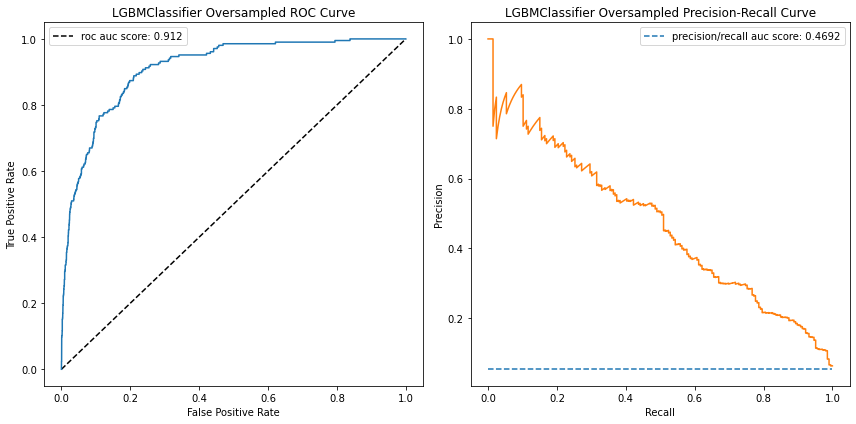

In [88]:
# sampling_strategy=.2 means increases the minority class to 20% of the data set
over_sample = RandomOverSampler(sampling_strategy=.2, random_state=23) 
light = lgb.LGBMClassifier(n_estimators=100, max_depth=10, random_state=23)

# oversampling must be done in a pipeline so only the training data is fit 
pipeline = make_pipeline(over_sample,light).fit(X_train.values,y_train)
model_name = 'LGBMClassifier Over Sampled'
parameters = {}

run_model(model=pipeline, model_name=model_name, fit=False,**parameters)
plot_eval_curves(model_name)

In [89]:
model_df[model_df.index.str.contains('LGBM')][['roc_auc','accuracy','precision-recall_auc','f1']]

,roc_auc,accuracy,precision-recall_auc,f1
LGBMClassifier,0.908223,0.949790,0.431246,0.305455
LGBMClassifier MCA,0.867258,0.947950,0.362483,0.307692
LGBMClassifier Oversampled,0.911981,0.948212,0.469158,0.471850


Oversampling gave a nice boost. Let's see if we can tune this further.

#### Bayseian Hyperparamter Tuning

In [67]:
#reduced sample space

# define an objective function to be maximized
def objective_resample(trial):

    # suggest values for the hyperparameters using a trial object
    
    # LGBM classifier hyperparameters
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt','dart','goss'])
    num_leaves = trial.suggest_int('num_leaves', 10, 100, 5)
    max_depth = trial.suggest_int('max_depth', -1, 100)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf',5, 100, 5)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500,10)
    objective = 'binary'
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    #reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 3)
    #reg_lambda = trial.suggest_uniform('reg_lambda', 0.0, 3)
    
    #over sampling parameter
    ros_sampling_strategy = trial.suggest_discrete_uniform('sampling_strategy', 0.1, 1, 0.05)
    
    # pipeline objects 
    over_sample = RandomOverSampler(sampling_strategy=ros_sampling_strategy, random_state=23)
    
    light = lgb.LGBMClassifier(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                           learning_rate=learning_rate, n_estimators=n_estimators, objective=objective,
                           class_weight=class_weight, min_data_in_leaf=min_data_in_leaf,
                           random_state=23)
    
    # make folds and pipeline                         
    kf = KFold(n_splits=5, random_state=23, shuffle=True)
    pipeline = make_pipeline(over_sample, light)
    
    # object to maximize = mean of 5 fold cross validation f1 score
    cv = cross_val_score(pipeline, X_train.values, y_train, cv=kf, n_jobs=-1, scoring='f1')
    
    score = np.mean(cv)
    
    # if an invalid parameter combinations are tested this tells the sampler to avoid in the future
    if score == np.nan:
        raise optuna.structs.TrialPruned()
    return score

In [ ]:
# create a study object and optimize the objective function
start_time = time.time()
with warnings.catch_warnings():
    # suppress warnings for invalid parameter combinations
    warnings.simplefilter("ignore")
    sampler = TPESampler(seed=23) 
    study_resample = optuna.create_study(sampler=sampler, direction='maximize')
    study_resample.optimize(objective_resample, n_trials=1000)
end_time = time.time()
run_time = end_time - start_time
run_time

In [69]:
print(f'best parameters: {study_resample.best_params}')
print(f'best f1 score: {study_resample.best_value}')

best parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': 86, 'min_data_in_leaf': 50, 'learning_rate': 0.1213248267194798, 'n_estimators': 230, 'class_weight': None, 'sampling_strategy': 0.9}
best f1 score: 0.45778530494615693


#### Hyperparameter tuning results
best parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': 86, 'min_data_in_leaf': 50, 'learning_rate': 0.1213248267194798, 'n_estimators': 230, 'class_weight': None, 'sampling_strategy': 0.9}

best f1 score: 0.45778530494615693

In [78]:
#study_resample_results = study_resample.trials_dataframe()
#study_resample_results[study_resample_results['state'] == 'FAIL']
#study_resample_results.to_csv('Data/resample_tuning_results.csv')

,roc_auc,accuracy,precision-recall_auc,f1
LGBMClassifier Over Sampled Tuned,0.91204,0.939274,0.48937,0.498915


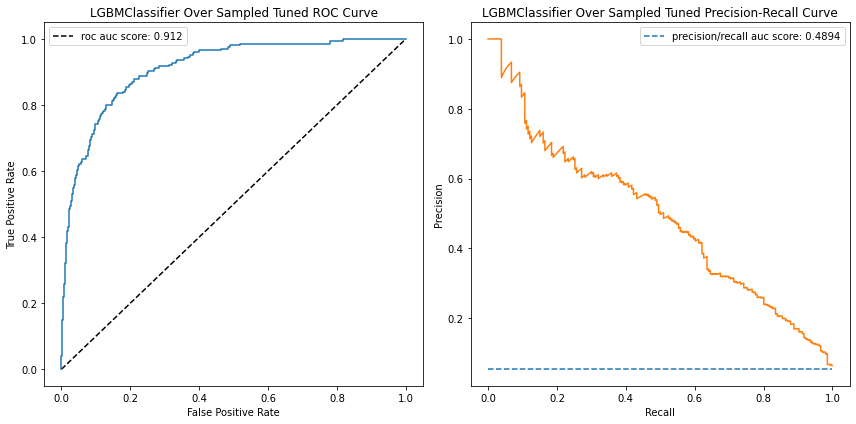

In [335]:
parameters = {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': 86,
              'min_data_in_leaf': 50, 'learning_rate': 0.1213248267194798,
              'n_estimators': 230, 'class_weight': None, 'random_state':23}

over_sample = RandomOverSampler(sampling_strategy=.9, random_state=23)
light = lgb.LGBMClassifier(**parameters)


pipeline = make_pipeline(over_sample,light).fit(X_train,y_train)
model_name = 'LGBMClassifier Over Sampled Tuned'


run_model(model=pipeline, model_name=model_name, fit=False,**parameters)
plot_eval_curves(model_name)

In [92]:
model_df[model_df.index.str.contains('LGBM')][['roc_auc','accuracy','precision-recall_auc','f1']]

,roc_auc,accuracy,precision-recall_auc,f1
LGBMClassifier,0.908223,0.949790,0.431246,0.305455
LGBMClassifier MCA,0.867258,0.947950,0.362483,0.307692
LGBMClassifier Oversampled,0.911981,0.948212,0.469158,0.471850
LGBMClassifier Over Sampled Tuned,0.912030,0.939274,0.489363,0.498915


By tuning the over sampled model we we able to increase the precision-recall_auc by 0.058 and the f1 score by 0.193 over the base model.

#### Thresholds

Classifier models return the probability that an observation is of a particular class. The assumption is that if the probability is greater than 0.5 than its a Top 1000 game. However, this is not set in stone and is a decision point for us to make a choice about whats more important, precision or recall. We can plot the precision and recall scores as a function of this threshold to find the appropriate thresholds for our uses.

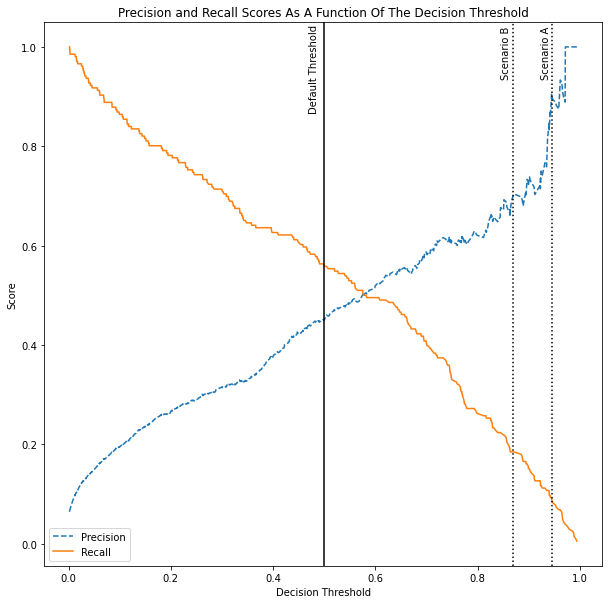

In [14]:
thresholds = model_df.loc['LGBMClassifier Over Sampled Tuned']['precision-recall_threshold']
precisions = model_df.loc['LGBMClassifier Over Sampled Tuned']['precision']
recalls = model_df.loc['LGBMClassifier Over Sampled Tuned']['recall']

_ = plt.figure(figsize=(10, 10))
_ = plt.title('Precision and Recall Scores As A Function Of The Decision Threshold')
_ = plt.plot(thresholds, precisions[:-1], '--', label='Precision')
_ = plt.plot(thresholds, recalls[:-1], '-', label='Recall')
_ = plt.axvline(x=0.5, c='black')
_ = plt.annotate('Default Threshold', xy=(0.47,0.87), rotation=90)
_ = plt.axvline(x=0.945, c='k', ls=':')
_ = plt.annotate('Scenario A', xy=(0.925,0.94), rotation=90)
_ = plt.axvline(x=0.87, c='k', ls=':')
#_ = plt.hlines(.7,xmin=0,xmax=1)
#_ = plt.hlines(.9,xmin=0,xmax=1)
_ = plt.annotate('Scenario B', xy=(0.845,0.94), rotation=90)
_ = plt.ylabel('Score')
_ = plt.xlabel('Decision Threshold')
_ = plt.legend(loc='best')

Developing a board game is resourse intensive in both time and cost, so precision is the primary metric to determine the threshold we want to use. There are two scenarios regard the decision threshold to be considered depending on the situation of the game publisher.

<b>Scenario A:</b> This publisher is new. Perhaps they are a startup or a hobbyist trying to break into the market with a Kickstarter campaign. For this publisher a failure would be fatal, so they require high precision. At this threshold the model has trouble finding the games that fall into Top 1000, but when a top game is identified it is confident in the prediction. The threshold I reccomend in this scenario is 0.945 representing a .90 precision score.

In [230]:
print('Classification Report for Scenario A')
print(classification_report(y_test, y_pred_A))

Classification Report for Scenario A
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3598
           1       0.90      0.09      0.16       206

    accuracy                           0.95      3804
   macro avg       0.93      0.54      0.57      3804
weighted avg       0.95      0.95      0.93      3804



<b>Scenario B:</b> In this scenario the game publisher is an established business with a sucessful track history and has experienced game developers on staff. Due to their expertise in the industry they have more flexibility and can trade off some precision for a greater variety in the potential games they are looking to make. They might not get the best combination of features in their game, but with their vast domain knowledge they will still be able to make a successful game. The threshold for this scenario is 0.87 representing a 0.7 precision score.

In [231]:
print('Classification Report for Scenario B')
print(classification_report(y_test, y_pred_B))

Classification Report for Scenario B
              precision    recall  f1-score   support

           0       0.96      1.00      0.97      3598
           1       0.70      0.18      0.29       206

    accuracy                           0.95      3804
   macro avg       0.83      0.59      0.63      3804
weighted avg       0.94      0.95      0.94      3804



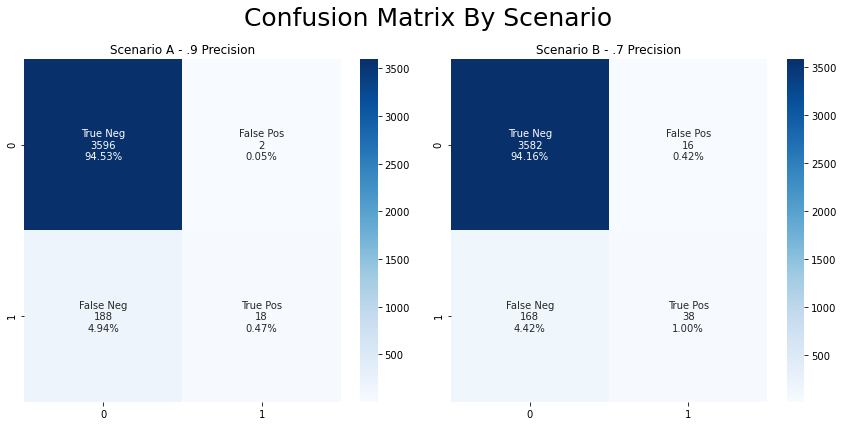

In [16]:
# Adjusting the threshold from 0.50 to 0.925
y_pred_A = np.where(light.predict_proba(X_test)[:,1] >= 0.945, 1, 0)

# Adjusting the threshold from 0.50 to 0.87
y_pred_B = np.where(light.predict_proba(X_test)[:,1] >= 0.87, 1, 0)

cmatrix_scenarioA = confusion_matrix(y_test, y_pred_A)
cmatrix_scenarioB = confusion_matrix(y_test, y_pred_B)

_ = plt.subplots(figsize=(12,6))
_ = plt.subplot(1,2,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cmatrix_scenarioA.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmatrix_scenarioA.flatten()/np.sum(cmatrix_scenarioA)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cmatrix_scenarioA, annot=labels, cmap='Blues', fmt='')
_ = plt.title('Scenario A - .9 Precision')

_ = plt.subplot(1,2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cmatrix_scenarioB.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmatrix_scenarioB.flatten()/np.sum(cmatrix_scenarioB)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cmatrix_scenarioB, annot=labels, cmap='Blues', fmt='')
_ = plt.title('Scenario B - .7 Precision')
_ = plt.suptitle("Confusion Matrix By Scenario", size=25)

plt.tight_layout()

The confusion matrix illuminates the trade off between false positives and true positives for each scenario. Regardless of the threshold, we can see that the model has difficulty identifying the positive class.

# Conslusion





The combination of unbalanced classes and the high cardinality with a dataset on the smaller side clearly cause difficulty in prediction. To improve predictive power we could increase the size of the positive class and target the top 2,500 games instead of only the top 1,000 with the understanding that the true positives may not be as highly rated. Additionally, careful consideration while reducing the number of category and mechanic features reduction will likely show improvement.

However, most importantly, we should remember that what makes a board game "fun" is a highly subjective matter. As we saw, Monopoly is one of the worst rated games, but also a household name and by and large a commercial success. We also see categories and mechanics representing games at both ends of the ranks. Other aspects such as artwork, story, and even the quality of the game components can be just as important in a game's success. In other words, games are more than just the sum of their features. 

That said, the features are still important and I choose a tree based model so that we can explore them. The below chart shows feature important by gain for the top 20 features. All 6 numerical features are highly represented here suggesting optimal ranges for these features. We also only see the Wargame and Humor categories while the majority of the top features by gain are mechanics. I've included the partial dependency plots at the end of this notebook for the numericals features. The idea is that these plots tell us how a given feature influences the model predictions after “averaging out” the influence of the other features. The key takeaways are:

- min and max players have minimal influence
- as max playtime increase it's influence increases until about 300 minutes then levels out
- increases in min playtime peaks in influence around 120 minutes then sees a decline
- weight's influence generally increases but dips at 2 before increasing again
- the influence of age increases until 12 where it dips, and peaks again around 16

From EDA we saw positive correlations in Geek Rating from age and weight. There was a minimal correlation from min and max playtime, and slightly negative correlations from min and max players.

Lastly, we should examine select false positives and false negatives in order to better understand how a game is more than just the sum of its features.

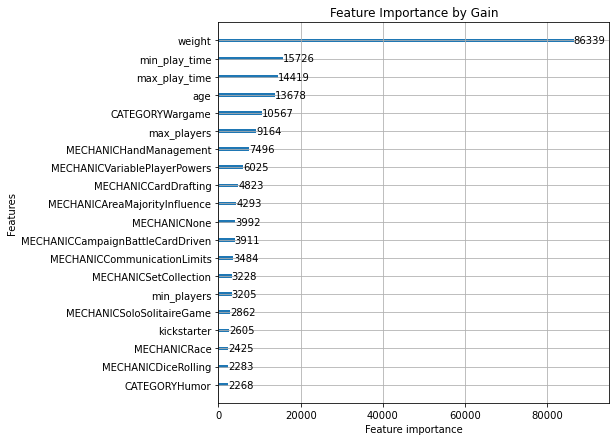

In [243]:
_ = lgb.plot_importance(light,max_num_features=20, importance_type='gain', precision=0, title='Feature Importance by Gain', figsize=(7,7))

In [123]:
# recreating train test splits keeping individual game data (title, url, etc.)
bgg_pred = pd.read_csv('Data/browse_cmf_credits_raw.csv', index_col=0)
bgg_pred.fillna('None', inplace=True)
bgg_pred['kickstarter'] = bgg_pred['family'].str.contains('Kickstarter')
bgg_pred.drop(columns=['family'], inplace=True)
bgg_pred['top_1000'] = bgg_pred['rank'] <= 1000
bgg_pred['top_1000'].replace({True:1,False:0}, inplace=True)


X2 = bgg_pred.drop(columns=['top_1000'])
y = bgg_pred.top_1000

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=23, shuffle=True)

# creating y_pred, actuals and y_pred_proba dataframes
predicted = model_df.loc['LGBMClassifier Over Sampled Tuned']['y_pred']
predicted = pd.DataFrame(predicted, columns=['predicted'])
actual = pd.DataFrame(y_test, columns=['top_1000'])
probability = model_df.loc['LGBMClassifier Over Sampled Tuned']['y_pred_prob']
probability = pd.DataFrame(probability, columns=['probability'])

# combining dataframes and creating a column indicating false positives and false negatives
pred_df = pd.concat([X2_test.reset_index(drop=True), predicted.reset_index(drop=True), actual.reset_index(drop=True), probability.reset_index(drop=True)], axis=1)
pred_df['class'] = pred_df['predicted'] - pred_df['top_1000']
pred_df['class'].replace({1:'False Positive',0:'Correct',-1:'False Negative'}, inplace=True)

# false positive and false negative dataframes
false_pos = pred_df[pred_df['class'] == 'False Positive']
false_neg = pred_df[pred_df['class'] == 'False Negative']

#### False positive games with the highest predicted probability

In [128]:
false_pos.drop(columns=['game_id']).sort_values(by=['probability'], ascending=False).head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,category,mechanic,age,max_play_time,max_players,min_play_time,min_players,weight,kickstarter,predicted,top_1000,probability,class
3580,6.49,5.936,1138,Uchronia,https://boardgamegeek.com/boardgame/128063/uchronia/credits,2628,"'Ancient', 'Card Game', 'City Building', 'Prehistoric'","'Card Drafting', 'Follow', 'Hand Management', 'Set Collection', 'Take That', 'Variable Phase Order'",14,60,5,45,2,2.732,False,1,0,0.971343,False Positive
1483,7.79,6.341,908,Last Bastion,https://boardgamegeek.com/boardgame/285984/last-bastion/credits,1278,"'Fantasy', 'Fighting', 'Medieval'","'Cooperative Game', 'Dice Rolling', 'Die Icon Resolution', 'Grid Movement', 'Modular Board', 'Move Through Deck', 'P...",14,45,4,45,1,2.541,False,1,0,0.958929,False Positive
1485,6.80,5.784,432,Michael Strogoff,https://boardgamegeek.com/boardgame/224894/michael-strogoff/credits,3633,"'Novel-based', 'Racing'","'Dice Rolling', 'Hand Management', 'Player Elimination', 'Point to Point Movement', 'Push Your Luck', 'Race'",12,60,5,60,1,2.143,False,1,0,0.942624,False Positive
2815,6.86,6.269,1879,Impulse,https://boardgamegeek.com/boardgame/144239/impulse/credits,1460,"'Bluffing', 'Card Game', 'Economic', 'Fighting', 'Science Fiction', 'Space Exploration'","'Action Queue', 'Area Majority / Influence', 'Card Play Conflict Resolution', 'Grid Movement', 'Hand Management', 'M...",13,60,6,30,2,2.965,False,1,0,0.940353,False Positive
221,6.79,5.655,200,Magic: The Gathering – Heroes of Dominaria Board Game,https://boardgamegeek.com/boardgame/248763/magic-gathering-heroes-dominaria-board-game/credits,5351,'Fantasy',"'Automatic Resource Growth', 'Events', 'Network and Route Building', 'Pick-up and Deliver', 'Point to Point Movement...",14,75,4,45,2,2.285,False,1,0,0.936963,False Positive


First let's examine the false positives with the highest predicted probabilites i.e. the games that the algorithm got completely wrong. The false positive [Uchronia](https://boardgamegeek.com/boardgame/128063/uchronia) (Rank 2628) is a great example. It has the right combination of mechanics, age and weight and by all accounts should be a top game. However, digging into the reviews, we can see where Uchronia fell short. User Papa Ninja summarizes these shortfalls in his review giving the game a 4/10:

"I have been wanting to play this one for a while since I really like Glory to Rome*. Personally I found this to be a far cry from GtR; in my opinion all of the tension and interesting card synergies are missing. The locations are all very lackluster and are just worth 1, 2 or 3 points with very generic powers. The worst part of the game is how poorly the theme is tied into the game. Dinosaurs, awesome... except none of the theme comes through with any of the cards. This game was a major disappointment and not something I would seek out to play again." 

**Uchronia's gameplay is a based on the game mechanics of [Glory to Rome](https://boardgamegeek.com/boardgame/19857/glory-rome) (Rank 184)*

Another prime example of a game that looks great on paper, but ultimately misses the mark with the implementation is [Magic: The Gathering – Heroes of Dominaria Board Game](https://boardgamegeek.com/boardgame/248763/magic-gathering-heroes-dominaria-board-game/) (Rank 5351) which attempts to draw from the imensely popular [Magic: The Gathering](https://boardgamegeek.com/boardgame/463/magic-gathering) (Rank 150) universe. Again we can look to the negative reviews to learn more.

- 4/10 "Rather bland. So much could be pulled from the magic universe, this is really vanilla." user bneffer
- 3/10 "This game is the okay-est game I've played. It is inoffensive, unless there is any art by Noah Bradley have not checked yet. If you can get me less than $10 than it can stop your board games from falling over on your shelf." user The Game Piece
- 3/10 "This is competent and just as exciting as something you would describe as competent." user Goregrimm

Despite the right components, this game is succintly summarized by these reviews as "uninspiring". 

#### False negatives games with the lowest predicted probability

In [333]:
false_neg.drop(columns=['game_id']).sort_values(by=['probability'], ascending=True).head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,category,mechanic,age,max_play_time,max_players,min_play_time,min_players,weight,kickstarter,predicted,top_1000,probability,class
2545,7.64,7.109,4587,KLASK,https://boardgamegeek.com/boardgame/165722/klask/credits,289,"'Action / Dexterity', 'Real-time'",None,8,10,2,10,2,1.055,False,0,1,0.001859,False Negative
1457,7.34,6.506,1878,Legacy of Dragonholt,https://boardgamegeek.com/boardgame/234669/legacy-dragonholt/credits,971,"'Adventure', 'Exploration', 'Fantasy'","'Cooperative Game', 'Narrative Choice / Paragraph', 'Role Playing', 'Storytelling'",14,999,6,60,1,1.200,False,0,1,0.002448,False Negative
3376,6.84,6.490,4475,The Magic Labyrinth,https://boardgamegeek.com/boardgame/41916/magic-labyrinth/credits,994,"""Children's Game"", 'Fantasy', 'Maze', 'Memory'","'Dice Rolling', 'Grid Movement', 'Memory', 'Network and Route Building', 'Roll / Spin and Move'",6,30,4,20,2,1.236,False,0,1,0.002466,False Negative
254,7.20,6.718,3964,Britannia,https://boardgamegeek.com/boardgame/240/britannia/credits,678,"'Ancient', 'Civilization', 'Medieval', 'Wargame'","'Area Movement', 'Dice Rolling', 'Stat Check Resolution', 'Voting'",12,300,5,180,3,3.168,False,0,1,0.012544,False Negative
688,6.92,6.740,11845,Ca$h 'n Guns (Second Edition),https://boardgamegeek.com/boardgame/155362/cah-n-guns-second-edition/credits,648,"'Bluffing', 'Fighting', 'Humor', 'Mafia', 'Negotiation', 'Party Game'","'Card Drafting', 'Player Elimination', 'Simultaneous Action Selection', 'Take That', 'Variable Player Powers'",10,30,8,30,4,1.264,False,0,1,0.015048,False Negative


To wrap up, we can move on to the other end of the spectrum by taking a deeper look at the games that the model gave the lowest probability of being a top 1000 game, but actually are.

What we can see here are games that are exceptions where game design trumps expectations. They generally have low weight, and have unpopular categories or mechanics such as action/dexterity, children's game, party game, roll spin and move, and memory.

For example, [KLASK](https://boardgamegeek.com/boardgame/165722/klask/) (rank 289), which can be described as a small scale version of foosball or air hockey, by all accounts should be a terrible game; action/dexterity is not a highly rated category, and both age and weight don't align with the trends we saw. But, this is an exception. User cuazzel summarizes this well with their 9/10 rating: "I HATE dexterity games. This should say enough about my rating".

#### Partial Dependency Plots

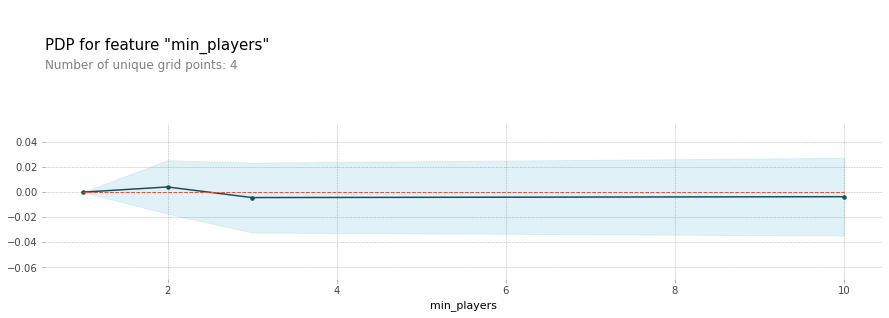

In [400]:
pdp_minplayer = pdp.pdp_isolate(model=light, dataset=X_train, model_features=X_train.columns,feature='min_players')
fig, ax = pdp.pdp_plot(pdp_isolate_out=pdp_minplayer, feature_name='min_players', figsize=(15,5))
ax['pdp_ax'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x*bgg.min_players.max())))

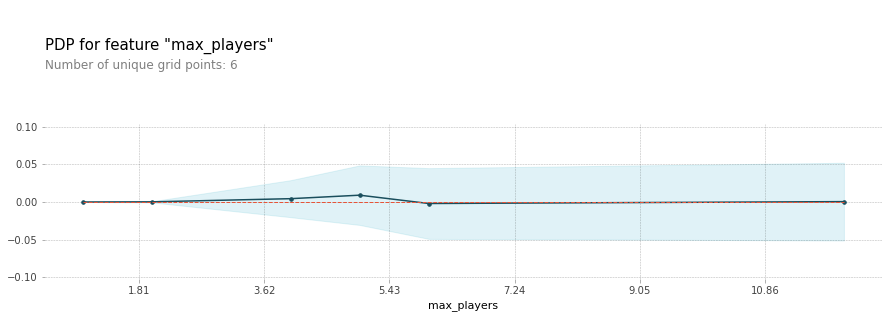

In [408]:
pdp_maxplayer = pdp.pdp_isolate(model=light, dataset=X_train, model_features=X_train.columns,feature='max_players', percentile_range=(0,97))
fig, ax = pdp.pdp_plot(pdp_isolate_out=pdp_maxplayer, feature_name='max_players', figsize=(15,5))
ax['pdp_ax'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x*bgg.max_players.max())))

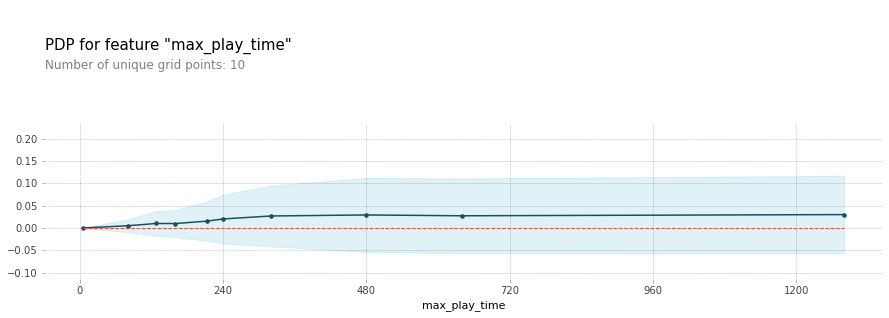

In [398]:
pdp_maxtime = pdp.pdp_isolate(model=light, dataset=X_train, model_features=X_train.columns,feature='max_play_time',percentile_range=(0,95))
fig, ax = pdp.pdp_plot(pdp_isolate_out=pdp_maxtime, feature_name='max_play_time',figsize=(15,5))
ax['pdp_ax'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x*bgg.max_play_time.max())))

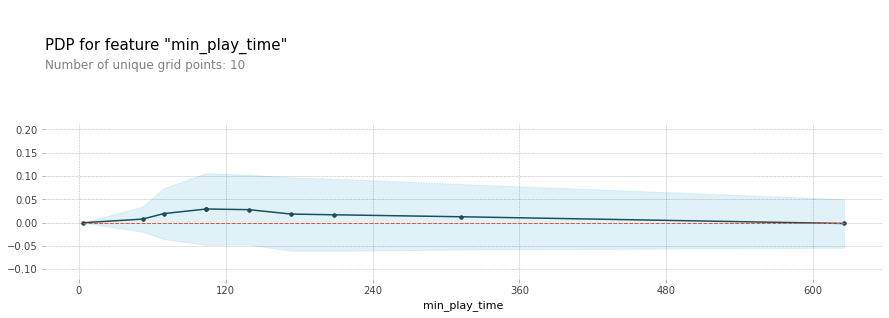

In [397]:
pdp_mintime = pdp.pdp_isolate(model=light, dataset=X_train, model_features=X_train.columns,feature='min_play_time',percentile_range=(0,95))
fig, ax = pdp.pdp_plot(pdp_isolate_out=pdp_mintime, feature_name='min_play_time',figsize=(15,5))
ax['pdp_ax'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x*bgg.min_play_time.max())))

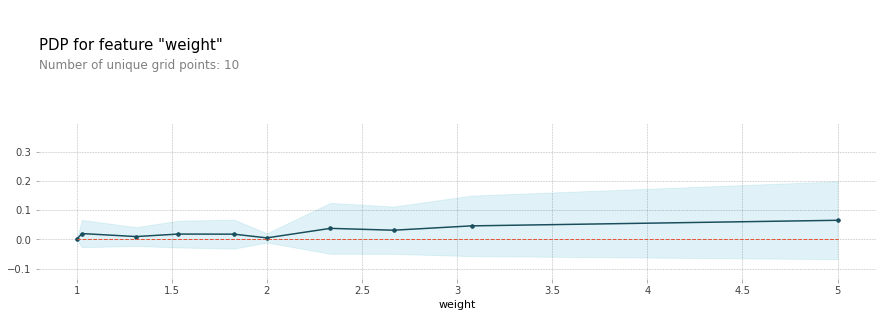

In [396]:
pdp_weight = pdp.pdp_isolate(model=light, dataset=X_train, model_features=X_train.columns,feature='weight')
fig, ax = pdp.pdp_plot(pdp_isolate_out=pdp_weight, feature_name='weight',figsize=(15,5))
ax['pdp_ax'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x*bgg.weight.max())))

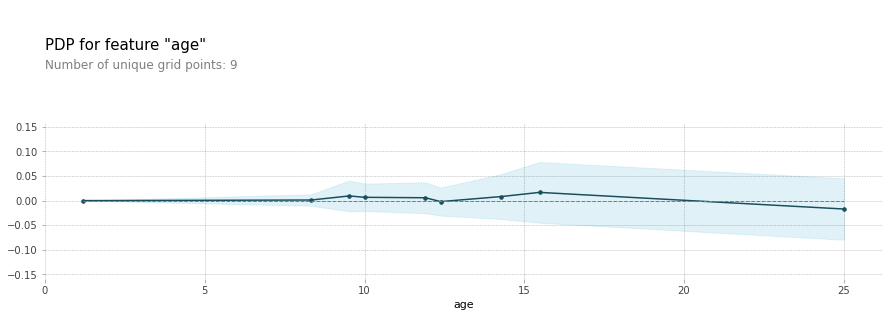

In [411]:
pdp_age = pdp.pdp_isolate(model=light, dataset=X_train, model_features=X_train.columns,feature='age')
fig, ax = pdp.pdp_plot(pdp_isolate_out=pdp_age, feature_name='age', figsize=(15,5))
ax['pdp_ax'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x*bgg.age.max())))